# ASE

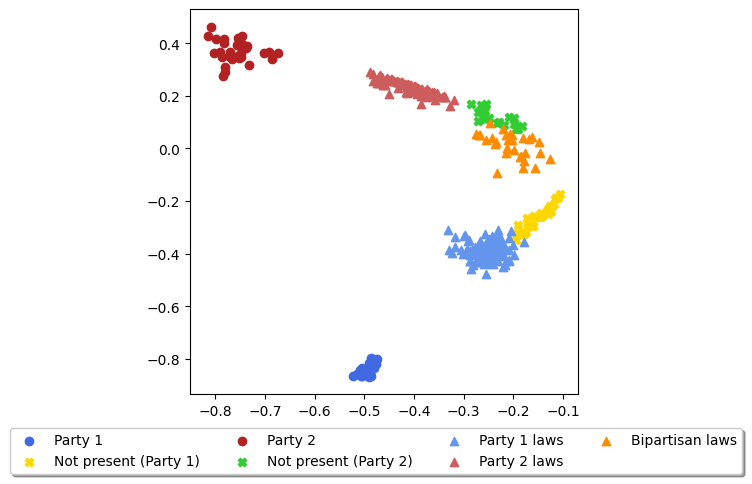

In [28]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.utils import stochastic_blockmodel_graph, to_dense_adj, erdos_renyi_graph
from graspologic.embed import AdjacencySpectralEmbed 

## BIPARTITE
d = 4
n_P1 = 50
n_P2 = 50
n_L1 = 100
n_L2 = 100
n_L3 = 30

P1_L1 = 0.9
P1_L2 = 0.01
P1_L3 = 0.2  
P2_L1 = 0.1
P2_L2 = 0.8
P2_L3 = 0.3


p = [
    [0, 0, P1_L1, P1_L2, P1_L3],
    [0, 0, P2_L1, P2_L2, P2_L3],
    [P1_L1, P2_L1, 0, 0, 0], 
    [P1_L2, P2_L2, 0, 0, 0], 
    [P1_L3, P2_L3, 0, 0, 0]
    ]

n = [n_P1, n_P2, n_L1, n_L2, n_L3]
num_nodes = np.sum(n)

edge_index = stochastic_blockmodel_graph(n, p)

n_P1_np = 30
n_P2_np = 18
senadores_no_presentes = list(range(n_P1_np)) + list(range(n_P1,n_P1+n_P2_np))

mask = torch.ones([num_nodes,num_nodes]).squeeze(0)
for i in senadores_no_presentes:
    votos = (torch.rand(1, num_nodes) < 0.3).int()
    mask[i,:] = votos
    mask[:,i] = votos



adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0).numpy()
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
# ase = AdjacencySpectralEmbed(n_elbows = 2, diag_aug=True)
masked_adj = adj_matrix*mask.numpy()
x_ase = ase.fit_transform(masked_adj)
x_ase = torch.from_numpy(x_ase)
 


plt.figure(figsize=(5,5))
plt.scatter(x_ase[n_P1_np:n_P1,0],x_ase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
plt.scatter(x_ase[:n_P1_np,0],x_ase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
plt.scatter(x_ase[n_P1+n_P2_np:n_P1+n_P2,0],x_ase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
plt.scatter(x_ase[n_P1:n_P1+n_P2_np,0],x_ase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
plt.scatter(x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
plt.scatter(x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
plt.scatter(x_ase[n_P1+n_P2+n_L1+n_L2:,0],x_ase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
plt.legend(loc='upper center', bbox_to_anchor=(0.48, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()


In [29]:
A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
list_q.sort(reverse=True)
q = torch.Tensor(list_q)
q

tensor([ 1.,  1., -1., -1.])

# GD

Iteraciones:  100
Loss:  tensor(55.3782)


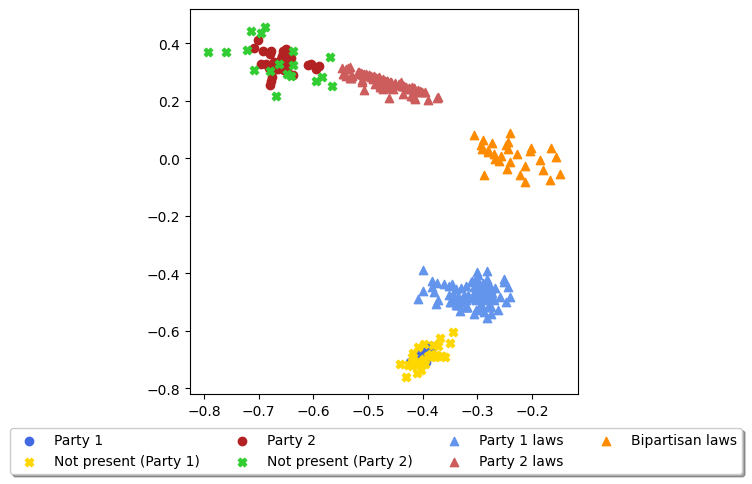

In [30]:
import sys
sys.path.append("../")

from models.RDPG_GD import GRDPG_GD_Armijo
import math
from training.get_init import get_x_init
from models.SVD_truncate import align_Xs


Q=torch.diag(q)
x  = get_x_init(num_nodes, d, 0, math.pi/2, 0, math.pi/2)
x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()
print("Iteraciones: ", k)
print("Loss: ", torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask.nonzero().t().contiguous()).squeeze(0)))
x_grdpg = align_Xs(x_grdpg, x_ase)



plt.figure(figsize=(5,5))
plt.scatter(x_grdpg[n_P1_np:n_P1,0],x_grdpg[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
plt.scatter(x_grdpg[:n_P1_np,0],x_grdpg[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
plt.scatter(x_grdpg[n_P1+n_P2_np:n_P1+n_P2,0],x_grdpg[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
plt.scatter(x_grdpg[n_P1:n_P1+n_P2_np,0],x_grdpg[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
plt.scatter(x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
plt.scatter(x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
plt.scatter(x_grdpg[n_P1+n_P2+n_L1+n_L2:,0],x_grdpg[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
plt.legend(loc='upper center', bbox_to_anchor=(0.48, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()

# GLASE

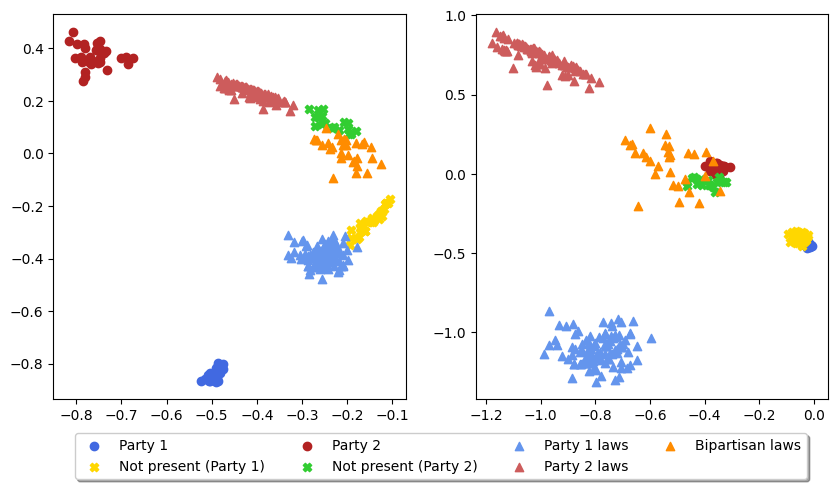

In [31]:
import sys
sys.path.append("../")

from models.GLASE_unshared_normalized import gLASE 
import math
from training.get_init import get_x_init
from models.SVD_truncate import align_Xs


Q=torch.diag(q)
gd_steps=10

edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous()

glase = gLASE(d, d, gd_steps)
glase.load_state_dict(torch.load('../saved_models/lase_unshared_normalized_unbalanced_bipartite_xase_10steps.pt'))
glase.eval()

x_glase = glase(x_ase, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
x_glase = x_glase.detach()

x_glase = align_Xs(x_glase,x_ase)


fig, axes = plt.subplots(1, 2, figsize =(10,5))
axes[0].scatter(x_ase[n_P1_np:n_P1,0],x_ase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[0].scatter(x_ase[:n_P1_np,0],x_ase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[0].scatter(x_ase[n_P1+n_P2_np:n_P1+n_P2,0],x_ase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[0].scatter(x_ase[n_P1:n_P1+n_P2_np,0],x_ase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[0].scatter(x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1+n_L2:,0],x_ase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[1].scatter(x_glase[n_P1_np:n_P1,0],x_glase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[1].scatter(x_glase[:n_P1_np,0],x_glase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[1].scatter(x_glase[n_P1+n_P2_np:n_P1+n_P2,0],x_glase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[1].scatter(x_glase[n_P1:n_P1+n_P2_np,0],x_glase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[1].scatter(x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[1].scatter(x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[1].scatter(x_glase[n_P1+n_P2+n_L1+n_L2:,0],x_glase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
plt.legend(loc='upper center', bbox_to_anchor=(-0.1, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()


# GLASE - d=4

In [33]:
import sys
sys.path.append("../")

import torch
import numpy as np
from torch_geometric.utils import stochastic_blockmodel_graph, to_dense_adj
from graspologic.embed import AdjacencySpectralEmbed 
from models.RDPG_GD import GRDPG_GD_Armijo
from models.GLASE_unshared_normalized import gLASE 
# from models.GLASE_unshared_normalized_v2 import gLASE_v2
import matplotlib.pyplot as plt

torch.manual_seed(42)

d = 4
n_P1 = 50
n_P2 = 50
n_L1 = 100
n_L2 = 100
n_L3 = 30

P1_L1 = 0.9
P1_L2 = 0.01
P1_L3 = 0.2  
P2_L1 = 0.1
P2_L2 = 0.8
P2_L3 = 0.3


p = [
    [0, 0, P1_L1, P1_L2, P1_L3],
    [0, 0, P2_L1, P2_L2, P2_L3],
    [P1_L1, P2_L1, 0, 0, 0], 
    [P1_L2, P2_L2, 0, 0, 0], 
    [P1_L3, P2_L3, 0, 0, 0]
    ]

n = [n_P1, n_P2, n_L1, n_L2, n_L3]

num_nodes = np.sum(n)
edge_index = stochastic_blockmodel_graph(n, p)


## MASK
n_P1_np = 30
n_P2_np = 18
senadores_no_presentes = list(range(n_P1_np)) + list(range(n_P1,n_P1+n_P2_np))

mask = torch.ones([num_nodes,num_nodes]).squeeze(0)
for i in senadores_no_presentes:
    votos = (torch.rand(1, num_nodes) < 0.1).int()
    mask[i,:] = votos
    mask[:,i] = votos


## ASE 
adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0).numpy()
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
masked_adj = adj_matrix*mask.numpy()
x_ase = ase.fit_transform(masked_adj)
x_ase = torch.from_numpy(x_ase)

A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
        
# list_q.sort(reverse=True)
q = torch.Tensor(list_q)
Q=torch.diag(q)

print(Q)


torch.norm((x_ase@Q@x_ase.T - to_dense_adj(edge_index).squeeze(0))*mask)



x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()
print("Iteraciones: ", k)
print("Loss: ", torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask.nonzero().t().contiguous()).squeeze(0)))




tensor([[ 1.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0., -1.]])
Iteraciones:  100
Loss:  tensor(51.4385)


In [34]:
gd_steps = 10
lr = 1e-2
device = 'cuda'
model = gLASE(d,d, gd_steps)
model.to(device)


epochs = 1000

## Initialization
for step in range(gd_steps):
    model.gd[step].lin1.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin1.weight)*lr
    model.gd[step].lin2.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin2.weight)*lr
    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define ATT mask
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = mask.to(device)
x_ase = x_ase.to(device)
edge_index = edge_index.to(device)
Q = Q.to(device)

for epoch in range(epochs):
    # Train
    model.train()

    optimizer.zero_grad()
    out = model(x_ase, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
    loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
    loss.backward() 
    optimizer.step() 

    if epoch % 100 ==0:
        print(loss)


tensor(57.2344, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(53.7426, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(51.8291, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(52.0957, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(51.7572, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(51.7586, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(51.7133, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(51.7546, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(51.7612, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(51.7379, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


tensor(51.7030, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


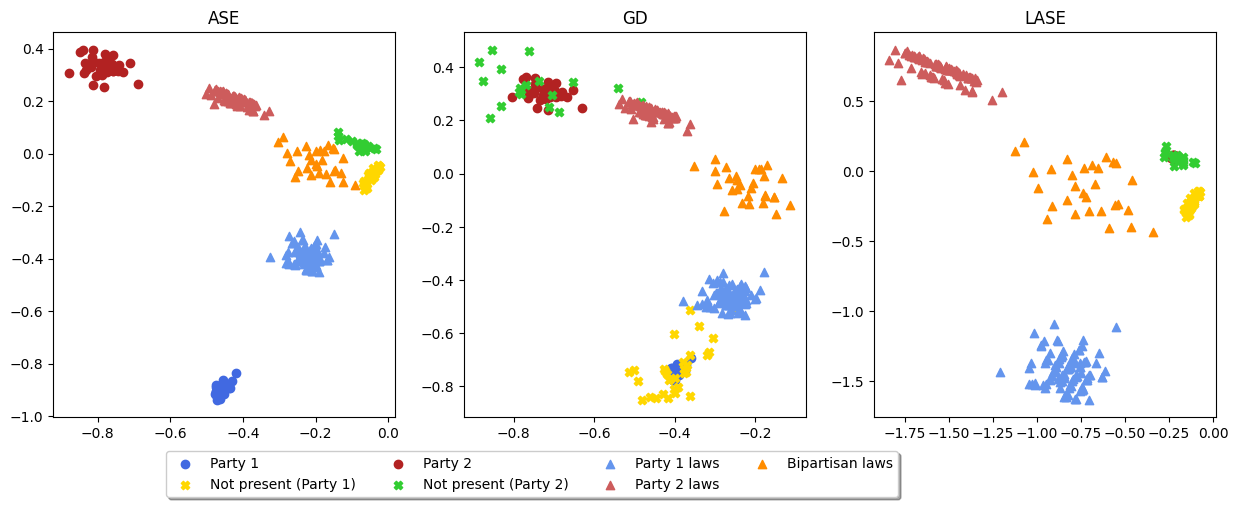

In [35]:
loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
print(loss)
x_glase = out.detach().to('cpu')
x_ase = x_ase.to('cpu')



# out = align_Xs(out, x_ase.to('cpu'))

fig, axes = plt.subplots(1, 3, figsize =(15,5))
axes[0].scatter(x_ase[n_P1_np:n_P1,0],x_ase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[0].scatter(x_ase[:n_P1_np,0],x_ase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[0].scatter(x_ase[n_P1+n_P2_np:n_P1+n_P2,0],x_ase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[0].scatter(x_ase[n_P1:n_P1+n_P2_np,0],x_ase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[0].scatter(x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1+n_L2:,0],x_ase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[0].set_title('ASE')

axes[1].scatter(x_grdpg[n_P1_np:n_P1,0],x_grdpg[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[1].scatter(x_grdpg[:n_P1_np,0],x_grdpg[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[1].scatter(x_grdpg[n_P1+n_P2_np:n_P1+n_P2,0],x_grdpg[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[1].scatter(x_grdpg[n_P1:n_P1+n_P2_np,0],x_grdpg[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[1].scatter(x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[1].scatter(x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[1].scatter(x_grdpg[n_P1+n_P2+n_L1+n_L2:,0],x_grdpg[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[1].set_title('GD')

axes[2].scatter(x_glase[n_P1_np:n_P1,0],x_glase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[2].scatter(x_glase[:n_P1_np,0],x_glase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[2].scatter(x_glase[n_P1+n_P2_np:n_P1+n_P2,0],x_glase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[2].scatter(x_glase[n_P1:n_P1+n_P2_np,0],x_glase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[2].scatter(x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[2].scatter(x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[2].scatter(x_glase[n_P1+n_P2+n_L1+n_L2:,0],x_glase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[2].set_title('LASE')
plt.legend(loc='upper center', bbox_to_anchor=(-1, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()

## Cambio en arq

In [8]:
import sys
sys.path.append("../")

import torch
import numpy as np
from torch_geometric.utils import stochastic_blockmodel_graph, to_dense_adj
from graspologic.embed import AdjacencySpectralEmbed 
from models.RDPG_GD import GRDPG_GD_Armijo
# from models.GLASE_unshared_normalized import gLASE 
from models.GLASE_unshared_normalized_v2 import gLASE_v2
import matplotlib.pyplot as plt

torch.manual_seed(42)

d = 4
n_P1 = 50
n_P2 = 50
n_L1 = 100
n_L2 = 100
n_L3 = 30

P1_L1 = 0.9
P1_L2 = 0.01
P1_L3 = 0.2  
P2_L1 = 0.1
P2_L2 = 0.8
P2_L3 = 0.3


p = [
    [0, 0, P1_L1, P1_L2, P1_L3],
    [0, 0, P2_L1, P2_L2, P2_L3],
    [P1_L1, P2_L1, 0, 0, 0], 
    [P1_L2, P2_L2, 0, 0, 0], 
    [P1_L3, P2_L3, 0, 0, 0]
    ]

n = [n_P1, n_P2, n_L1, n_L2, n_L3]

num_nodes = np.sum(n)
edge_index = stochastic_blockmodel_graph(n, p)


## MASK
n_P1_np = 5
n_P2_np = 3
senadores_no_presentes = list(range(n_P1_np)) + list(range(n_P1,n_P1+n_P2_np))

mask = torch.ones([num_nodes,num_nodes]).squeeze(0)
for i in senadores_no_presentes:
    votos = (torch.rand(1, num_nodes) < 0.1).int()
    mask[i,:] = votos
    mask[:,i] = votos


## ASE 
adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0).numpy()
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
masked_adj = adj_matrix*mask.numpy()
x_ase = ase.fit_transform(masked_adj)
x_ase = torch.from_numpy(x_ase)

A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
        
# list_q.sort(reverse=True)
q = torch.Tensor(list_q)
Q=torch.diag(q)

print(Q)


torch.norm((x_ase@Q@x_ase.T - to_dense_adj(edge_index).squeeze(0))*mask)



x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()
print("Iteraciones: ", k)
print("Loss: ", torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask.nonzero().t().contiguous()).squeeze(0)))




tensor([[ 1.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0., -1.]])
Iteraciones:  100
Loss:  tensor(64.7776)


In [13]:
gd_steps = 15
lr = 1e-2
device = 'cuda'
model = gLASE_v2(d,d, gd_steps)
model.to(device)


epochs = 1000

## Initialization
for step in range(gd_steps):
    model.gd[step].lin1.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin1.weight)*lr
    # model.gd[step].lin2.weight.data = (torch.eye(d,d)*lr).to(device)#torch.nn.init.xavier_uniform_(model.gd[step].lin2.weight)*lr
    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define ATT mask
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = mask.to(device)
x_ase = x_ase.to(device)
edge_index = edge_index.to(device)
Q = Q.to(device)

for epoch in range(epochs):
    # Train
    model.train()

    optimizer.zero_grad()
    out = model(x_ase, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
    loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
    loss.backward() 
    optimizer.step() 

    if epoch % 100 ==0:
        print(loss)


tensor(65.5396, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(65.0312, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(64.9002, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(64.8422, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(64.8230, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(64.8134, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(64.8071, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(64.8025, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(64.8008, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(64.7985, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


tensor(64.7966, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


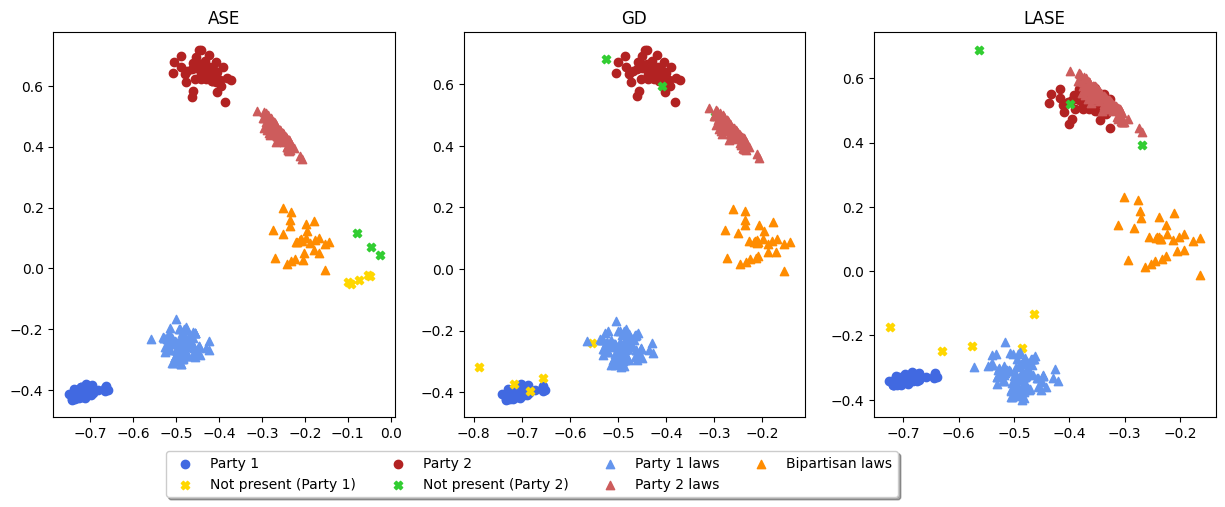

In [14]:
loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
print(loss)

x_glase = out.detach().to('cpu')
x_ase = x_ase.to('cpu')

# out = align_Xs(out, x_ase.to('cpu'))

fig, axes = plt.subplots(1, 3, figsize =(15,5))
axes[0].scatter(x_ase[n_P1_np:n_P1,0],x_ase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[0].scatter(x_ase[:n_P1_np,0],x_ase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[0].scatter(x_ase[n_P1+n_P2_np:n_P1+n_P2,0],x_ase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[0].scatter(x_ase[n_P1:n_P1+n_P2_np,0],x_ase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[0].scatter(x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1+n_L2:,0],x_ase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[0].set_title('ASE')

axes[1].scatter(x_grdpg[n_P1_np:n_P1,0],x_grdpg[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[1].scatter(x_grdpg[:n_P1_np,0],x_grdpg[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[1].scatter(x_grdpg[n_P1+n_P2_np:n_P1+n_P2,0],x_grdpg[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[1].scatter(x_grdpg[n_P1:n_P1+n_P2_np,0],x_grdpg[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[1].scatter(x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[1].scatter(x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[1].scatter(x_grdpg[n_P1+n_P2+n_L1+n_L2:,0],x_grdpg[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[1].set_title('GD')

axes[2].scatter(x_glase[n_P1_np:n_P1,0],x_glase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[2].scatter(x_glase[:n_P1_np,0],x_glase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[2].scatter(x_glase[n_P1+n_P2_np:n_P1+n_P2,0],x_glase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[2].scatter(x_glase[n_P1:n_P1+n_P2_np,0],x_glase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[2].scatter(x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[2].scatter(x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[2].scatter(x_glase[n_P1+n_P2+n_L1+n_L2:,0],x_glase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[2].set_title('LASE')
plt.legend(loc='upper center', bbox_to_anchor=(-1, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()

# MLP Classifier

In [6]:
import random 

indexes = [x for x in range(num_nodes) if x not in senadores_no_presentes]
num_train = int(0.8*len(indexes))
num_val = len(indexes) - num_train
num_test = len(senadores_no_presentes)
random.shuffle(indexes)

train_idx = indexes[:num_train]
val_idx = indexes[num_train:]

test_idx = senadores_no_presentes

In [7]:
labels = np.concatenate((np.ones(n_P1)*0,np.ones(n_P2), np.ones(n_L1)*2, np.ones(n_L2)*3, np.ones(n_L3)*4))
labels = labels.tolist()
labels = torch.tensor(labels)

In [8]:
import random 
from models.glase_classifier import MultiLayerPerceptron
from torch import nn
from models.early_stopper import EarlyStopper

device = 'cuda'

x_glase = x_glase.to(device)
labels = labels.to(device)

embedding_dim = 4  # dimensionality of the graph embeddings
h_embedding_dim = 10
output_dim = 5  # number of classes
n_layers = 3
dropout = 0.5
epochs = 200
lr=1e-2


model = MultiLayerPerceptron(embedding_dim, h_embedding_dim, output_dim, n_layers, dropout)
model.to(device)    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopper(patience=10, min_delta=0)

train_loss_epoch=[]
val_loss_epoch=[]
test_loss_epoch=[]
best_valid_acc = 0
best_epoch = 0

# start = time.time()

for epoch in range(epochs):
    ## Train
    model.train()
    optimizer.zero_grad()
    out = model(x_glase[train_idx])
    loss =  criterion(out, labels[train_idx].squeeze().long())

    loss.backward() 
    optimizer.step() 
    
    # Calculate accuracy
    _, predicted_labels = torch.max(out,1)
    total_train_correct = (predicted_labels.squeeze() == labels[train_idx]).sum().item()
    total_train_samples = num_train
    train_acc = total_train_correct / total_train_samples
    total_train_loss = loss.item()    

    ## Val
    model.eval()
    out = model(x_glase[val_idx])
    loss =  criterion(out, labels[val_idx].squeeze().long())
        
    # Calculate accuracy
    _, predicted_labels = torch.max(out,1)
    total_val_correct = (predicted_labels.squeeze() == labels[val_idx]).sum().item()
    total_val_samples = num_val
    valid_acc = total_val_correct / total_val_samples
    total_val_loss = loss.item()        
    
    ## Test
    model.eval()
    out = model(x_glase[test_idx])
    loss =  criterion(out, labels[test_idx].squeeze().long())
    
    # Calculate accuracy
    _, predicted_labels = torch.max(out,1)
    total_test_correct = (predicted_labels.squeeze() == labels[test_idx]).sum().item()
    total_test_samples = num_test
    test_acc = total_test_correct / total_test_samples
    total_test_loss = loss.item()     
           
    train_loss_epoch.append(total_train_loss)
    val_loss_epoch.append(total_val_loss)
    test_loss_epoch.append(total_test_loss)
    
    if valid_acc >= best_valid_acc:
        best_valid_acc = valid_acc
        # torch.save(model.state_dict(), MODEL_FILE)
        best_epoch = epoch
    
    # Print epoch statistics
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {total_train_loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

print(best_epoch)


Epoch: 00, Loss: 1.6909, Train: 14.01%, Valid: 16.92% Test: 37.50%
Epoch: 01, Loss: 1.6804, Train: 14.01%, Valid: 16.92% Test: 37.50%
Epoch: 02, Loss: 1.6637, Train: 14.01%, Valid: 16.92% Test: 37.50%
Epoch: 03, Loss: 1.6425, Train: 14.01%, Valid: 16.92% Test: 37.50%
Epoch: 04, Loss: 1.6184, Train: 14.01%, Valid: 16.92% Test: 37.50%
Epoch: 05, Loss: 1.6053, Train: 14.40%, Valid: 16.92% Test: 37.50%
Epoch: 06, Loss: 1.5924, Train: 14.79%, Valid: 16.92% Test: 37.50%
Epoch: 07, Loss: 1.5457, Train: 19.46%, Valid: 16.92% Test: 37.50%
Epoch: 08, Loss: 1.5353, Train: 22.18%, Valid: 16.92% Test: 37.50%
Epoch: 09, Loss: 1.5247, Train: 24.90%, Valid: 16.92% Test: 37.50%
Epoch: 10, Loss: 1.5186, Train: 25.68%, Valid: 58.46% Test: 50.00%
Epoch: 11, Loss: 1.4581, Train: 31.13%, Valid: 61.54% Test: 100.00%
Epoch: 12, Loss: 1.4563, Train: 35.02%, Valid: 61.54% Test: 100.00%
Epoch: 13, Loss: 1.4376, Train: 36.58%, Valid: 61.54% Test: 100.00%
Epoch: 14, Loss: 1.4136, Train: 40.47%, Valid: 72.31% Test:

# Classifier v2

In [8]:
device = 'cuda'
features = torch.zeros(n_P1+n_P2, n_L1+n_L2+n_L3)

for i in range(n_P1+n_P2):
    features[i] = torch.tensor(masked_adj[i,n_P1+n_P2])

features = features.to(device)

In [9]:
import random 

indexes = [x for x in range(n_P1+n_P2) if x not in senadores_no_presentes]
num_train = int(0.8*len(indexes))
num_val = len(indexes) - num_train
num_test = len(senadores_no_presentes)
random.shuffle(indexes)

train_idx = indexes[:num_train]
val_idx = indexes[num_train:]

test_idx = senadores_no_presentes

In [10]:
labels = np.concatenate((np.ones(n_P1)*0,np.ones(n_P2)))
labels = labels.tolist()
labels = torch.tensor(labels)

In [11]:
import random 
from models.glase_classifier import MultiLayerPerceptron
from torch import nn
from models.early_stopper import EarlyStopper

device = 'cuda'

x_glase = x_glase.to(device)
labels = labels.to(device)

embedding_dim = 230  # dimensionality of the graph embeddings
h_embedding_dim = 32
output_dim = 2  # number of classes
n_layers = 3
dropout = 0.5
epochs = 200
lr=1e-2


model = MultiLayerPerceptron(embedding_dim, h_embedding_dim, output_dim, n_layers, dropout)
model.to(device)    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopper(patience=10, min_delta=0)

train_loss_epoch=[]
val_loss_epoch=[]
test_loss_epoch=[]
best_valid_acc = 0
best_epoch = 0

# start = time.time()

for epoch in range(epochs):
    ## Train
    model.train()
    optimizer.zero_grad()
    out = model(features[train_idx])
    loss =  criterion(out, labels[train_idx].squeeze().long())

    loss.backward() 
    optimizer.step() 
    
    # Calculate accuracy
    _, predicted_labels = torch.max(out,1)
    total_train_correct = (predicted_labels.squeeze() == labels[train_idx]).sum().item()
    total_train_samples = num_train
    train_acc = total_train_correct / total_train_samples
    total_train_loss = loss.item()    

    ## Val
    model.eval()
    out = model(features[val_idx])
    loss =  criterion(out, labels[val_idx].squeeze().long())
        
    # Calculate accuracy
    _, predicted_labels = torch.max(out,1)
    total_val_correct = (predicted_labels.squeeze() == labels[val_idx]).sum().item()
    total_val_samples = num_val
    valid_acc = total_val_correct / total_val_samples
    total_val_loss = loss.item()        
    
    ## Test
    model.eval()
    out = model(features[test_idx])
    loss =  criterion(out, labels[test_idx].squeeze().long())
    
    # Calculate accuracy
    _, predicted_labels = torch.max(out,1)
    total_test_correct = (predicted_labels.squeeze() == labels[test_idx]).sum().item()
    total_test_samples = num_test
    test_acc = total_test_correct / total_test_samples
    total_test_loss = loss.item()     
           
    train_loss_epoch.append(total_train_loss)
    val_loss_epoch.append(total_val_loss)
    test_loss_epoch.append(total_test_loss)
    
    if valid_acc >= best_valid_acc:
        best_valid_acc = valid_acc
        # torch.save(model.state_dict(), MODEL_FILE)
        best_epoch = epoch
    
    # Print epoch statistics
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {total_train_loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

print(best_epoch)


Epoch: 00, Loss: 0.7228, Train: 38.36%, Valid: 57.89% Test: 62.50%
Epoch: 01, Loss: 0.6022, Train: 42.47%, Valid: 57.89% Test: 62.50%
Epoch: 02, Loss: 0.5729, Train: 46.58%, Valid: 57.89% Test: 62.50%
Epoch: 03, Loss: 0.6708, Train: 54.79%, Valid: 100.00% Test: 50.00%
Epoch: 04, Loss: 0.6024, Train: 71.23%, Valid: 100.00% Test: 50.00%
Epoch: 05, Loss: 0.4596, Train: 86.30%, Valid: 100.00% Test: 50.00%
Epoch: 06, Loss: 0.5361, Train: 90.41%, Valid: 100.00% Test: 50.00%
Epoch: 07, Loss: 0.4742, Train: 89.04%, Valid: 100.00% Test: 50.00%
Epoch: 08, Loss: 0.6094, Train: 87.67%, Valid: 100.00% Test: 50.00%
Epoch: 09, Loss: 0.4544, Train: 90.41%, Valid: 100.00% Test: 50.00%
Epoch: 10, Loss: 0.4428, Train: 90.41%, Valid: 100.00% Test: 50.00%
Epoch: 11, Loss: 0.3849, Train: 89.04%, Valid: 100.00% Test: 50.00%
Epoch: 12, Loss: 0.4810, Train: 84.93%, Valid: 100.00% Test: 50.00%
Epoch: 13, Loss: 0.4583, Train: 86.30%, Valid: 100.00% Test: 50.00%
Epoch: 14, Loss: 0.4934, Train: 89.04%, Valid: 100.

## ASE

In [17]:
import random 
from models.glase_classifier import MultiLayerPerceptron
from torch import nn
from models.early_stopper import EarlyStopper

device = 'cuda'

x_glase = x_glase.to(device)
x_ase = x_ase.to(device)
labels = labels.to(device)

embedding_dim = 4  # dimensionality of the graph embeddings
h_embedding_dim = 16
output_dim = 2  # number of classes
n_layers = 3
dropout = 0.5
epochs = 10
lr=1e-2


model = MultiLayerPerceptron(embedding_dim, h_embedding_dim, output_dim, n_layers, dropout)
model.to(device)    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopper(patience=10, min_delta=0)

train_loss_epoch=[]
val_loss_epoch=[]
test_loss_epoch=[]
best_valid_acc = 0
best_epoch = 0

# start = time.time()

for epoch in range(epochs):
    ## Train
    model.train()
    optimizer.zero_grad()
    out = model(x_ase[train_idx])
    loss =  criterion(out, labels[train_idx].squeeze().long())

    loss.backward() 
    optimizer.step() 
    
    # Calculate accuracy
    _, predicted_labels = torch.max(out,1)
    total_train_correct = (predicted_labels.squeeze() == labels[train_idx]).sum().item()
    total_train_samples = num_train
    train_acc = total_train_correct / total_train_samples
    total_train_loss = loss.item()    

    ## Val
    model.eval()
    out = model(x_ase[val_idx])
    loss =  criterion(out, labels[val_idx].squeeze().long())
        
    # Calculate accuracy
    _, predicted_labels = torch.max(out,1)
    total_val_correct = (predicted_labels.squeeze() == labels[val_idx]).sum().item()
    total_val_samples = num_val
    valid_acc = total_val_correct / total_val_samples
    total_val_loss = loss.item()        
    
    ## Test
    model.eval()
    out = model(x_ase[test_idx])
    loss =  criterion(out, labels[test_idx].squeeze().long())
    
    # Calculate accuracy
    _, predicted_labels = torch.max(out,1)
    total_test_correct = (predicted_labels.squeeze() == labels[test_idx]).sum().item()
    total_test_samples = num_test
    test_acc = total_test_correct / total_test_samples
    total_test_loss = loss.item()     
           
    train_loss_epoch.append(total_train_loss)
    val_loss_epoch.append(total_val_loss)
    test_loss_epoch.append(total_test_loss)
    
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        # torch.save(model.state_dict(), MODEL_FILE)
        best_epoch = epoch
    
    # Print epoch statistics
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {total_train_loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

print(best_epoch)


Epoch: 00, Loss: 0.7110, Train: 38.36%, Valid: 42.11% Test: 37.50%
Epoch: 01, Loss: 0.6967, Train: 52.05%, Valid: 42.11% Test: 37.50%
Epoch: 02, Loss: 0.6701, Train: 54.79%, Valid: 42.11% Test: 37.50%
Epoch: 03, Loss: 0.6622, Train: 54.79%, Valid: 42.11% Test: 37.50%
Epoch: 04, Loss: 0.6466, Train: 65.75%, Valid: 42.11% Test: 37.50%
Epoch: 05, Loss: 0.6299, Train: 64.38%, Valid: 100.00% Test: 37.50%
Epoch: 06, Loss: 0.6352, Train: 67.12%, Valid: 100.00% Test: 37.50%
Epoch: 07, Loss: 0.5996, Train: 82.19%, Valid: 100.00% Test: 50.00%
Epoch: 08, Loss: 0.6001, Train: 79.45%, Valid: 100.00% Test: 87.50%
Epoch: 09, Loss: 0.5628, Train: 84.93%, Valid: 100.00% Test: 100.00%
5


## GLASE

In [16]:
import random 
from models.glase_classifier import MultiLayerPerceptron
from torch import nn
from models.early_stopper import EarlyStopper

device = 'cuda'

x_glase = x_glase.to(device)
x_ase = x_ase.to(device)
labels = labels.to(device)

embedding_dim = 4  # dimensionality of the graph embeddings
h_embedding_dim = 16
output_dim = 2  # number of classes
n_layers = 3
dropout = 0.5
epochs = 10
lr=1e-2


model = MultiLayerPerceptron(embedding_dim, h_embedding_dim, output_dim, n_layers, dropout)
model.to(device)    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopper(patience=10, min_delta=0)

train_loss_epoch=[]
val_loss_epoch=[]
test_loss_epoch=[]
best_valid_acc = 0
best_epoch = 0

# start = time.time()

for epoch in range(epochs):
    ## Train
    model.train()
    optimizer.zero_grad()
    out = model(x_glase[train_idx])
    loss =  criterion(out, labels[train_idx].squeeze().long())

    loss.backward() 
    optimizer.step() 
    
    # Calculate accuracy
    _, predicted_labels = torch.max(out,1)
    total_train_correct = (predicted_labels.squeeze() == labels[train_idx]).sum().item()
    total_train_samples = num_train
    train_acc = total_train_correct / total_train_samples
    total_train_loss = loss.item()    

    ## Val
    model.eval()
    out = model(x_glase[val_idx])
    loss =  criterion(out, labels[val_idx].squeeze().long())
        
    # Calculate accuracy
    _, predicted_labels = torch.max(out,1)
    total_val_correct = (predicted_labels.squeeze() == labels[val_idx]).sum().item()
    total_val_samples = num_val
    valid_acc = total_val_correct / total_val_samples
    total_val_loss = loss.item()        
    
    ## Test
    model.eval()
    out = model(x_glase[test_idx])
    loss =  criterion(out, labels[test_idx].squeeze().long())
    
    # Calculate accuracy
    _, predicted_labels = torch.max(out,1)
    total_test_correct = (predicted_labels.squeeze() == labels[test_idx]).sum().item()
    total_test_samples = num_test
    test_acc = total_test_correct / total_test_samples
    total_test_loss = loss.item()     
           
    train_loss_epoch.append(total_train_loss)
    val_loss_epoch.append(total_val_loss)
    test_loss_epoch.append(total_test_loss)
    
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        # torch.save(model.state_dict(), MODEL_FILE)
        best_epoch = epoch
    
    # Print epoch statistics
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {total_train_loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

print(best_epoch)


Epoch: 00, Loss: 0.7067, Train: 45.21%, Valid: 57.89% Test: 62.50%
Epoch: 01, Loss: 0.7117, Train: 42.47%, Valid: 57.89% Test: 62.50%
Epoch: 02, Loss: 0.6992, Train: 49.32%, Valid: 57.89% Test: 62.50%
Epoch: 03, Loss: 0.6772, Train: 61.64%, Valid: 100.00% Test: 87.50%
Epoch: 04, Loss: 0.6579, Train: 69.86%, Valid: 100.00% Test: 100.00%
Epoch: 05, Loss: 0.6667, Train: 53.42%, Valid: 100.00% Test: 100.00%
Epoch: 06, Loss: 0.6454, Train: 71.23%, Valid: 100.00% Test: 87.50%
Epoch: 07, Loss: 0.5974, Train: 71.23%, Valid: 100.00% Test: 50.00%
Epoch: 08, Loss: 0.5923, Train: 76.71%, Valid: 100.00% Test: 50.00%
Epoch: 09, Loss: 0.6204, Train: 71.23%, Valid: 100.00% Test: 75.00%
3


# GAT Classifier

In [36]:
device = 'cuda'
features = torch.zeros(num_nodes, n_L1+n_L2+n_L3)

for i in range(n_P1+n_P2):
    features[i] = torch.tensor(masked_adj[i,n_P1+n_P2])

num_columns = features.size(1)
permuted_columns = torch.randperm(num_columns)
features = features[:, permuted_columns]

In [37]:
import random 

indexes = [x for x in range(n_P1+n_P2) if x not in senadores_no_presentes]
num_train = int(0.8*len(indexes))
num_val = len(indexes) - num_train
num_test = len(senadores_no_presentes)
random.shuffle(indexes)

train_idx = indexes[:num_train]
val_idx = indexes[num_train:]

test_idx = senadores_no_presentes

labels = np.concatenate((np.ones(n_P1)*0,np.ones(n_P2)))
labels = labels.tolist()
labels = torch.tensor(labels)

In [38]:
from models.glase_classifier import glaseClassifierGAT, FeatureClassifierGAT
import torch.nn as nn



feature_dim = 230 # dimensionality of the word embeddings
embedding_dim = d  # dimensionality of the graph embeddings
hidden_dim = 32  # number of hidden units
output_dim = 2  # number of classes
n_layers = 3
dropout1 = 0.5
dropout2 = 0.5 ## TODO: SACAR
device = 'cuda'
epochs = 1000
lr=1e-2


x_glase = x_glase.to(device)
labels = labels.to(device)
features = features.to(device)
edge_index = edge_index.to(device)

model = FeatureClassifierGAT(feature_dim, hidden_dim,output_dim, n_layers, dropout1, dropout2, num_heads=1)
model.to(device)    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_loss_epoch=[]
val_loss_epoch=[]
test_loss_epoch=[]
best_valid_acc = 0
best_epoch = 0


for epoch in range(epochs):
    ## Train
    model.train()
    optimizer.zero_grad()
    # out = model(data.x)
    out = model(features, edge_index)
    loss =  criterion(out[train_idx], labels[train_idx].squeeze().long())
    loss.backward() 
    optimizer.step() 
        
    # Calculate accuracy
    _, predicted_labels = torch.max(out[train_idx].squeeze(),1)
    total_train_correct = (predicted_labels.squeeze() == labels[train_idx].squeeze().to(device)).sum().item()
    total_train_samples = len(train_idx)
    train_acc = total_train_correct / total_train_samples
    total_train_loss = loss.item()    

    ## Val
    model.eval()
    # out = model(data.x)
    out = model(features, edge_index)
    loss =  criterion(out[val_idx], labels[val_idx].squeeze().long())
            
    # Calculate accuracy
    _, predicted_labels = torch.max(out[val_idx].squeeze(),1)
    total_val_correct = (predicted_labels.squeeze() == labels[val_idx].squeeze().to(device)).sum().item()
    total_val_samples = len(val_idx)
    valid_acc = total_val_correct / total_val_samples
    total_val_loss = loss.item()        
        
    ## Test
    loss =  criterion(out[test_idx], labels[test_idx].squeeze().long())
            
    # Calculate accuracy
    _, predicted_labels = torch.max(out[test_idx].squeeze(),1)
    total_test_correct = (predicted_labels.squeeze() == labels[test_idx].squeeze().to(device)).sum().item()
    total_test_samples = len(test_idx)
    test_acc = total_test_correct / total_test_samples
    total_test_loss = loss.item()      
            
    train_loss_epoch.append(total_train_loss)
    val_loss_epoch.append(total_val_loss)
    test_loss_epoch.append(total_test_loss)
    
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        # torch.save(model.state_dict(), MODEL_FILE_FEAT)
        best_epoch = epoch
        best_model = model

    if epoch % 100 == 0:        
        # Print epoch statistics
        print(f'Epoch: {epoch:02d}, '
            f'Loss: {total_train_loss:.4f}, '
            f'Train: {100 * train_acc:.2f}%, '
            f'Valid: {100 * valid_acc:.2f}% '
            f'Test: {100 * test_acc:.2f}%')

print(best_epoch) 


Epoch: 00, Loss: 0.5922, Train: 56.10%, Valid: 81.82% Test: 37.50%
Epoch: 100, Loss: 0.3876, Train: 90.24%, Valid: 81.82% Test: 37.50%
Epoch: 200, Loss: 0.0422, Train: 100.00%, Valid: 81.82% Test: 37.50%
Epoch: 300, Loss: 0.0655, Train: 100.00%, Valid: 81.82% Test: 37.50%
Epoch: 400, Loss: 0.1158, Train: 97.56%, Valid: 81.82% Test: 37.50%
Epoch: 500, Loss: 0.2820, Train: 95.12%, Valid: 81.82% Test: 37.50%
Epoch: 600, Loss: 0.0290, Train: 100.00%, Valid: 81.82% Test: 37.50%
Epoch: 700, Loss: 0.0045, Train: 100.00%, Valid: 81.82% Test: 37.50%
Epoch: 800, Loss: 0.0032, Train: 100.00%, Valid: 81.82% Test: 37.50%
Epoch: 900, Loss: 0.0023, Train: 100.00%, Valid: 81.82% Test: 37.50%
976


In [40]:
out = best_model(features, edge_index)
_, predicted_labels = torch.max(out[test_idx].squeeze(),1)
total_test_correct = (predicted_labels.squeeze() == labels[test_idx].squeeze().to(device)).sum().item()
total_test_samples = len(test_idx)
test_acc = total_test_correct / total_test_samples
test_acc

0.375

In [41]:
from models.glase_classifier import glaseClassifierGAT, FeatureClassifierGAT
import torch.nn as nn



feature_dim = 4 # dimensionality of the word embeddings
embedding_dim = d  # dimensionality of the graph embeddings
hidden_dim = 16  # number of hidden units
output_dim = 2  # number of classes
n_layers = 3
dropout1 = 0.5
dropout2 = 0.5 ## TODO: SACAR
device = 'cuda'
epochs = 1000
lr=1e-2


x_glase = x_glase.to(device)
x_ase = x_ase.to(device)
labels = labels.to(device)
features = features.to(device)
edge_index = edge_index.to(device)

model = FeatureClassifierGAT(feature_dim, hidden_dim,output_dim, n_layers, dropout1, dropout2, num_heads=1)
model.to(device)    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_loss_epoch=[]
val_loss_epoch=[]
test_loss_epoch=[]
best_valid_acc = 0
best_epoch = 0


for epoch in range(epochs):
    ## Train
    model.train()
    optimizer.zero_grad()
    # out = model(data.x)
    out = model(x_ase, edge_index)
    loss =  criterion(out[train_idx], labels[train_idx].squeeze().long())
    loss.backward() 
    optimizer.step() 
        
    # Calculate accuracy
    _, predicted_labels = torch.max(out[train_idx].squeeze(),1)
    total_train_correct = (predicted_labels.squeeze() == labels[train_idx].squeeze().to(device)).sum().item()
    total_train_samples = len(train_idx)
    train_acc = total_train_correct / total_train_samples
    total_train_loss = loss.item()    

    ## Val
    model.eval()
    # out = model(data.x)
    out = model(x_ase, edge_index)
    loss =  criterion(out[val_idx], labels[val_idx].squeeze().long())
            
    # Calculate accuracy
    _, predicted_labels = torch.max(out[val_idx].squeeze(),1)
    total_val_correct = (predicted_labels.squeeze() == labels[val_idx].squeeze().to(device)).sum().item()
    total_val_samples = len(val_idx)
    valid_acc = total_val_correct / total_val_samples
    total_val_loss = loss.item()        
        
    ## Test
    loss =  criterion(out[test_idx], labels[test_idx].squeeze().long())
            
    # Calculate accuracy
    _, predicted_labels = torch.max(out[test_idx].squeeze(),1)
    total_test_correct = (predicted_labels.squeeze() == labels[test_idx].squeeze().to(device)).sum().item()
    total_test_samples = len(test_idx)
    test_acc = total_test_correct / total_test_samples
    total_test_loss = loss.item()      
            
    train_loss_epoch.append(total_train_loss)
    val_loss_epoch.append(total_val_loss)
    test_loss_epoch.append(total_test_loss)
    
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        # torch.save(model.state_dict(), MODEL_FILE_FEAT)
        best_epoch = epoch
        best_model = model

    if epoch % 100 == 0:        
        # Print epoch statistics
        print(f'Epoch: {epoch:02d}, '
            f'Loss: {total_train_loss:.4f}, '
            f'Train: {100 * train_acc:.2f}%, '
            f'Valid: {100 * valid_acc:.2f}% '
            f'Test: {100 * test_acc:.2f}%')

print(best_epoch) 


Epoch: 00, Loss: 2.7892, Train: 43.90%, Valid: 81.82% Test: 37.50%
Epoch: 100, Loss: 0.0260, Train: 97.56%, Valid: 100.00% Test: 100.00%
Epoch: 200, Loss: 0.0066, Train: 100.00%, Valid: 100.00% Test: 100.00%
Epoch: 300, Loss: 0.0044, Train: 100.00%, Valid: 100.00% Test: 100.00%
Epoch: 400, Loss: 0.0015, Train: 100.00%, Valid: 100.00% Test: 100.00%
Epoch: 500, Loss: 0.0015, Train: 100.00%, Valid: 100.00% Test: 100.00%
Epoch: 600, Loss: 0.0006, Train: 100.00%, Valid: 100.00% Test: 100.00%
Epoch: 700, Loss: 0.0007, Train: 100.00%, Valid: 100.00% Test: 100.00%
Epoch: 800, Loss: 0.0002, Train: 100.00%, Valid: 100.00% Test: 100.00%
Epoch: 900, Loss: 0.0007, Train: 100.00%, Valid: 100.00% Test: 100.00%
26


In [43]:
out = best_model(x_ase, edge_index)
_, predicted_labels = torch.max(out[test_idx].squeeze(),1)
total_test_correct = (predicted_labels.squeeze() == labels[test_idx].squeeze().to(device)).sum().item()
total_test_samples = len(test_idx)
test_acc = total_test_correct / total_test_samples
test_acc

1.0

In [51]:
from models.glase_classifier import glaseClassifierGAT, FeatureClassifierGAT
import torch.nn as nn



feature_dim = 4 # dimensionality of the word embeddings
embedding_dim = d  # dimensionality of the graph embeddings
hidden_dim = 16  # number of hidden units
output_dim = 2  # number of classes
n_layers = 3
dropout1 = 0.5
dropout2 = 0.5 ## TODO: SACAR
device = 'cuda'
epochs = 1000
lr=1e-2


x_glase = x_glase.to(device)
x_ase = x_ase.to(device)
labels = labels.to(device)
features = features.to(device)
edge_index = edge_index.to(device)

model = FeatureClassifierGAT(feature_dim, hidden_dim,output_dim, n_layers, dropout1, dropout2, num_heads=1)
model.to(device)    

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_loss_epoch=[]
val_loss_epoch=[]
test_loss_epoch=[]
best_valid_acc = 0
best_epoch = 0


for epoch in range(epochs):
    ## Train
    model.train()
    optimizer.zero_grad()
    # out = model(data.x)
    out = model(x_glase, edge_index)
    loss =  criterion(out[train_idx], labels[train_idx].squeeze().long())
    loss.backward() 
    optimizer.step() 
        
    # Calculate accuracy
    _, predicted_labels = torch.max(out[train_idx].squeeze(),1)
    total_train_correct = (predicted_labels.squeeze() == labels[train_idx].squeeze().to(device)).sum().item()
    total_train_samples = len(train_idx)
    train_acc = total_train_correct / total_train_samples
    total_train_loss = loss.item()    

    ## Val
    model.eval()
    # out = model(data.x)
    out = model(x_glase, edge_index)
    loss =  criterion(out[val_idx], labels[val_idx].squeeze().long())
            
    # Calculate accuracy
    _, predicted_labels = torch.max(out[val_idx].squeeze(),1)
    total_val_correct = (predicted_labels.squeeze() == labels[val_idx].squeeze().to(device)).sum().item()
    total_val_samples = len(val_idx)
    valid_acc = total_val_correct / total_val_samples
    total_val_loss = loss.item()        
        
    ## Test
    loss =  criterion(out[test_idx], labels[test_idx].squeeze().long())
            
    # Calculate accuracy
    _, predicted_labels = torch.max(out[test_idx].squeeze(),1)
    total_test_correct = (predicted_labels.squeeze() == labels[test_idx].squeeze().to(device)).sum().item()
    total_test_samples = len(test_idx)
    test_acc = total_test_correct / total_test_samples
    total_test_loss = loss.item()      
            
    train_loss_epoch.append(total_train_loss)
    val_loss_epoch.append(total_val_loss)
    test_loss_epoch.append(total_test_loss)
    
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        # torch.save(model.state_dict(), MODEL_FILE_FEAT)
        best_epoch = epoch
        best_model = model

    if epoch % 100 == 0:        
        # Print epoch statistics
        print(f'Epoch: {epoch:02d}, '
            f'Loss: {total_train_loss:.4f}, '
            f'Train: {100 * train_acc:.2f}%, '
            f'Valid: {100 * valid_acc:.2f}% '
            f'Test: {100 * test_acc:.2f}%')

print(best_epoch) 


Epoch: 00, Loss: 0.6951, Train: 56.10%, Valid: 18.18% Test: 62.50%
Epoch: 100, Loss: 0.0011, Train: 100.00%, Valid: 100.00% Test: 100.00%
Epoch: 200, Loss: 0.0003, Train: 100.00%, Valid: 100.00% Test: 100.00%
Epoch: 300, Loss: 0.0001, Train: 100.00%, Valid: 100.00% Test: 100.00%
Epoch: 400, Loss: 0.0001, Train: 100.00%, Valid: 100.00% Test: 100.00%
Epoch: 500, Loss: 0.0000, Train: 100.00%, Valid: 100.00% Test: 100.00%
Epoch: 600, Loss: 0.0000, Train: 100.00%, Valid: 100.00% Test: 100.00%
Epoch: 700, Loss: 0.0000, Train: 100.00%, Valid: 100.00% Test: 100.00%
Epoch: 800, Loss: 0.0000, Train: 100.00%, Valid: 100.00% Test: 100.00%
Epoch: 900, Loss: 0.0001, Train: 100.00%, Valid: 100.00% Test: 100.00%
8


In [52]:
out = best_model(x_glase, edge_index)
_, predicted_labels = torch.max(out[test_idx].squeeze(),1)
total_test_correct = (predicted_labels.squeeze() == labels[test_idx].squeeze().to(device)).sum().item()
total_test_samples = len(test_idx)
test_acc = total_test_correct / total_test_samples
test_acc

1.0